In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 회귀
* kaggle [Weather in Szeged 2006-2016] dataset
* 실제 온도(Temperature)와 습도(Humidity)를 이용하여 체감 온도(Apparent Temperature) 예측하기

#### kaggle에서 dataset load
* 개발환경: 코랩

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"startingdataanalysis","key":"612e4754250bb25f880ea0b9e7d67c5b"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d budincsevity/szeged-weather

  0% 0.00/2.23M [00:00<?, ?B/s]
100% 2.23M/2.23M [00:00<00:00, 74.6MB/s]


In [6]:
! ls

kaggle.json  sample_data  szeged-weather.zip


In [7]:
! unzip szeged-weather.zip

Archive:  szeged-weather.zip
  inflating: weatherHistory.csv      


## Data load

In [8]:
data = pd.read_csv('./weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## 전처리
####**1) 중복 값 제거**

In [9]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(96429, 12)

####**2) 필요한 column만 사용**

In [10]:
data2 = data[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']]
data2.head()

,Temperature (C),Apparent Temperature (C),Humidity
0,9.472222,7.388889,0.89
1,9.355556,7.227778,0.86
2,9.377778,9.377778,0.89
3,8.288889,5.944444,0.83
4,8.755556,6.977778,0.83


In [11]:
data2.info()    # NOT NULL

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96429 entries, 0 to 96428
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           96429 non-null  float64
 1   Apparent Temperature (C)  96429 non-null  float64
 2   Humidity                  96429 non-null  float64
dtypes: float64(3)
memory usage: 2.2 MB


####**3) 이상치 제거**
* 모든 이상치가 normal data의 분포보다 작은 값을 가지고 있음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


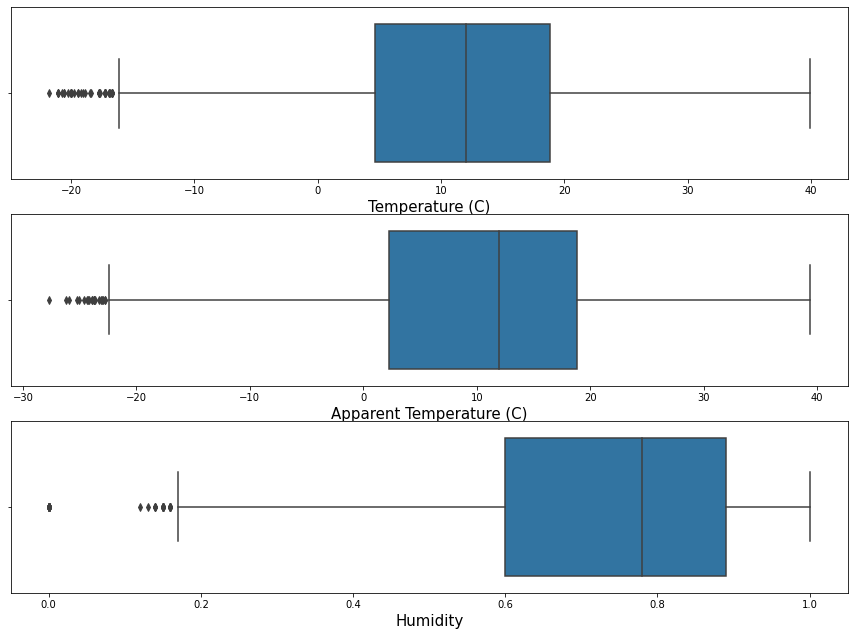

In [12]:
features = [feature for feature in data2.columns]

plt.figure(figsize=(15,45))
plotnumber =1
for feature in features:
    ax = plt.subplot(12, 1, plotnumber)
    sns.boxplot(data2[feature])
    plt.xlabel(feature, size=15)
    plotnumber += 1
plt.show()

In [13]:
data3 = data2.copy()

In [14]:
def draw_boxplots(feature,min_val,max_val):
    fig, axes = plt.subplots(1,2)
    plt.tight_layout(0.2)
    plt.figure(figsize=(15,10), facecolor='black')
    sns.boxplot(data2[feature],orient='h',ax=axes[0])
    axes[0].title.set_text("Before")
    sns.boxplot(data3[feature],orient='h',ax=axes[1])
    axes[1].title.set_text("After")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


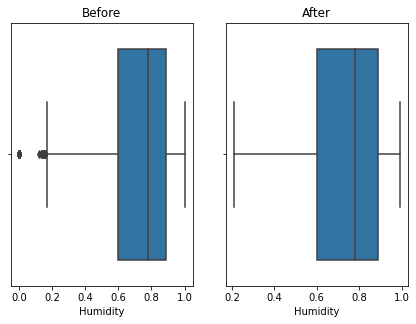

<Figure size 1080x720 with 0 Axes>

In [15]:
feature = 'Humidity'
min_val = 0.2
max_val = 1

data3 = data3[(data3[feature]>min_val) & (data3[feature]<max_val)]
draw_boxplots(feature, min_val, max_val)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


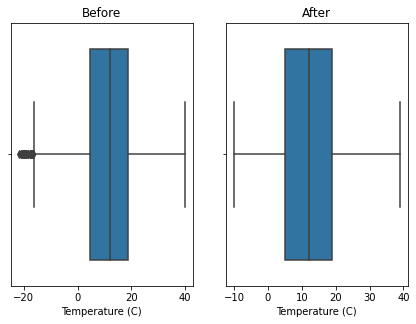

<Figure size 1080x720 with 0 Axes>

In [16]:
feature = 'Temperature (C)'
min_val = -10
max_val = 40

data3 = data3[(data3[feature]>min_val) & (data3[feature]<max_val)]
draw_boxplots(feature, min_val, max_val)

In [17]:
# target 값이므로 이상치를 제거하지 않음

# feature = 'Apparent Temperature (C)'
# min_val = -10
# max_val = 40

# data3 = data3[(data3[feature]>min_val) & (data3[feature]<max_val)]
# draw_boxplots(feature, min_val, max_val)

In [18]:
data3

,Temperature (C),Apparent Temperature (C),Humidity
0,9.472222,7.388889,0.89
1,9.355556,7.227778,0.86
2,9.377778,9.377778,0.89
3,8.288889,5.944444,0.83
4,8.755556,6.977778,0.83
...,...,...,...
96424,26.016667,26.016667,0.43
96425,24.583333,24.583333,0.48
96426,22.038889,22.038889,0.56
96427,21.522222,21.522222,0.60


####**4) train test split**

In [19]:
X = data3[['Temperature (C)', 'Humidity']].values
y = data3['Apparent Temperature (C)'].values

In [20]:
X.shape, y.shape

((92899, 2), (92899,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62242, 2), (30657, 2), (62242,), (30657,))

####**5) 스케일링**

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
X_train_scaled[:,1]

array([-0.13674075,  0.64411999, -0.91760149, ..., -0.60525719,
        1.2167512 , -0.60525719])

## 모델 훈련 및 검증

In [25]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [26]:
y_hat = model.predict(X_test_scaled)

In [27]:
R_square = model.score(X_test_scaled, y_test)
R_square

0.9865482897487862

In [28]:
mse = mean_squared_error(y_test, y_hat)
mse

1.4770924587797984

* 추정된 회귀식: $y=10.76194357x_1+0.44915053x_2+11.240609324179134$


In [29]:
model.coef_, model.intercept_

(array([10.76194357,  0.44915053]), 11.240609324179134)

# 분류
* MNIST Dataset 이용
* 다중 분류 문제
* RandomForestClassifier 이용

## Data 로드

In [30]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [31]:
X, y = mnist["data"], mnist["target"]
type(y[0])

str

## 전처리
* y의 type이 string이므로 int형으로 변환
* 모든 feature에 대해 scaling

In [32]:
y = y.astype(np.uint8)

In [33]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.astype(np.float64))

## 모델 훈련

In [34]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_predict_prob = cross_val_predict(forest_clf, X_scaled, y, cv=3,
                                    method="predict_proba")

* 모든 샘플이 한번 씩 예측됨

In [35]:
y_predict_prob.shape

(70000, 10)

* 첫번째 샘플의 각 클래스로 예측 될 확률값이 관찰됨
* 이미 모델 내에서 softmax가 됨을 알 수 있음
* 첫번째 샘플의 레이블인 5번 클래스의 확률이 가장 높음 => 옳게 예측

In [36]:
y_predict_prob[0]

array([0.01, 0.03, 0.03, 0.18, 0.01, 0.67, 0.01, 0.01, 0.04, 0.01])

In [37]:
y[0]

5